# Modelling Soil Organic Carbon (SOC) as a function of landcover type 

*Soils are the largest terrestrial organic C sink, and most climate models suggest that there will be global decreases in soil organic C (SOC) stocks due to global warming and associated changes in hydrologial regimes. These changes have the potential to be fairly strong positive feedbacks in global climate change, and also have regional implications for human land uses that are tied to soil carbon such as the productivity and resilience of agriculture and forestry. We need geospatial models of historical changes in soil organic C stocks in order to improve models under climate scenarios. However, there are not many studies that use available legacy datasets to perform space-for-time substitution SOC mapping.*

*My big-picture solution is to use the US NCSS’s Soil Characterization Database to develop a data-driven machine learning model that predicts SOC stock as a function of soil type, land cover (dynamic - at time of sampling), climate (dynamic - at time of sampling), and terrain. *

*For this MVP, I'm going to subset out just the samples from MN from this NCSS database. I will model SOC as a function of modelled landcover class (from USGS CONUS) and year. I don't expect that this model will do a good job, but it demostrates my ability to use a dynamic attribute to predict SOC. Using this framework, one could easily identify and add other static and dynamic variables*

In [46]:
### Import necessary packages
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import fiona
import rasterio
import rioxarray as rxr
from rasterio.plot import plotting_extent

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
pd.options.mode.chained_assignment = None

## Data Prep 

### Import soils data 

In [2]:
# National Cooperative soil survey point data for world
NCSS_file = "./MVP1_data/NCSS_Soil_Characterization_Database_09_14_2018.gdb"

### Subset dataframes to interest area, MN
For MVP 1, I am just interested in proof of concept and am going to work with a subset of data in MN so that computations, mapping, etc. go quickly and I have less data to comb through for errors.

In [3]:
pedonSites = gpd.read_file(NCSS_file, layer='NCSS_Site_Location')

In [4]:
# subsetting SSURGO data to site locations in MN
pedonSites = gpd.read_file(NCSS_file, layer='NCSS_Site_Location')
pedons_MN = pedonSites[(pedonSites['state_code']== "MN")]

# When I map this, it is clear that there are some mislabeled pedons in canada so I take those out by latitude.
# There is also one in ND but I'm not worried about that since it's close so I keep it in 
pedons_MN = pedons_MN[(pedons_MN['latitude_decimal_degrees'] < 60)]

# also subsetting out to just the columns that I want/need since there are otherwise 68
pedons_MN = pedons_MN[['site_key', 'site_obsdate', 'state_code', 'PedonName', 'geometry']]

# Finally, add a column 'year' with observation year read from observation date string
pedons_MN['year'] = pedons_MN['site_obsdate'].str[-4:]
pedons_MN.head()

,site_key,site_obsdate,state_code,PedonName,geometry,year
542,1654,7/11/1954,MN,Webster,POINT (-93.64995 43.86472),1954
543,1658,9/3/1960,MN,Zimmerman,POINT (-93.69746 45.52277),1960
544,1668,10/1/1968,MN,Cloquet,POINT (-92.63333 46.63334),1968
545,1673,10/1/1967,MN,Flaming,POINT (-96.28167 47.45556),1967
547,1681,7/1/1972,MN,Lupton,POINT (-93.50000 47.50000),1972


In [5]:
# see what layers are in the gdb and what we might want to use
layers = fiona.listlayers(NCSS_file)
#layers

### Exploratory maps

In [6]:
# Map of points in NCSS data and the year they were sampled
states = gpd.read_file("./MVP1_data/US_States/s_22mr22.shp")

base = MN.plot(color='white', edgecolor='black', figsize=(11, 11))
# make sure pedons coordinates line up
pedons_MN = pedons_MN.to_crs(MN.crs)

pedons_MN.plot(ax = base, column = 'year', legend = True)
## surpressing legend right now because it is long but otherwise would want to add legend = TRUE to the call 

NameError: name 'MN' is not defined

It looks like most of the observations are from 1978-1983 and 2010-2016. There are intially 2098 pedons we can consider. 

## Wrangling and transoformations of soil pedon data

### Wrangling NCSS gdb information into one dataframe

The NCSS soils geodatabase is terribly organized. I have to do a **3 way** join to get the point data, which also has the year information, joined to the attribute data. The attribute data are also all in different layers(ex I have to join both soil C and bulk density). Also, there's no key to what the column names are so I wasted a lot of time trying to figure out what everything was. 

The three ways are: 
- NCSS_Site_Location - NCSS_Pedon_Taxonomy joined by site_key
- NCSS_Pedon_Taxonomy - NCSS_Layer joined by pedon_key
- NCSS_Layer - [all the attribute layers I want, ex. soil C and bulk density] joined by labsampnum

In [7]:
layers = fiona.listlayers(NCSS_file)
#layers

In [8]:
# merge NCSS_Site_Location with NCSS_Pedon_Taxonomy into Sites_attributes
# Read in Pedon Taxonomy file
NCSS_Pedon_Taxonomy = gpd.read_file(NCSS_file, layer='NCSS_Pedon_Taxonomy')
#list(NCSS_Pedon_Taxonomy.columns)
#NCSS_Pedon_Taxonomy.head()

# left joining to only keep MN subset but also keep all of it
# I also only want a few columns out of the NCSS_Pedon_Taxonomy layer; pedon_key, site_key
Sites_attributes = pedons_MN.merge(NCSS_Pedon_Taxonomy[['pedon_key','site_key']], on = 'site_key', how = 'left')
Sites_attributes.head()

,site_key,site_obsdate,state_code,PedonName,geometry,year,pedon_key
0,1654,7/11/1954,MN,Webster,POINT (-93.64995 43.86472),1954,1654
1,1658,9/3/1960,MN,Zimmerman,POINT (-93.69746 45.52277),1960,1658
2,1668,10/1/1968,MN,Cloquet,POINT (-92.63333 46.63334),1968,1668
3,1673,10/1/1967,MN,Flaming,POINT (-96.28167 47.45556),1967,1673
4,1681,7/1/1972,MN,Lupton,POINT (-93.50000 47.50000),1972,1681


There are 20 more samples in the merged df than in the subset to MN pedon location df. There must be some sites where there are multiple pedons. For this reason we will calculate SOC grouped by pedon_key rather than site_key

In [9]:
## Read in NCSS_Layer
NCSS_Layer = gpd.read_file(NCSS_file, layer = 'NCSS_Layer')
#list(NCSS_Layer.columns)
#NCSS_Layer.head()

# Merge sites_attributes with NCSS_Layer
# Again, I only want a subset of the columns, but this time I want more of them
Sites_attributes = Sites_attributes.merge(NCSS_Layer[['pedon_key','labsampnum','site_key','layer_sequence', 'layer_type','hzn_top', 'hzn_bot']], on = ['pedon_key','site_key'], how = 'left')

In [10]:
# Read in Carbon_and_Extractions layer
Carbon_and_Extractions = gpd.read_file(NCSS_file, layer = 'Carbon_and_Extractions')
#list(Carbon_and_Extractions.columns)

# Merge sites_attributes with carbon_and_extractions layer
Sites_attributes = Sites_attributes.merge(Carbon_and_Extractions[['labsampnum','c_tot','c_tot_code','oc','oc_code']], on = 'labsampnum', how = 'left')

#Read in Bulk density layer
Bulk_Density_and_Moisture = gpd.read_file(NCSS_file, layer = 'Bulk_Density_and_Moisture')
# Merge sites_attributes with bulk_density layer (selecting 'db_od', bulk density over dry, misspelled aghhhh)
Sites_attributes = Sites_attributes.merge(Bulk_Density_and_Moisture[['labsampnum','db_od']], on = 'labsampnum', how = 'left')

Some of the soils don't have bulk density data or soil C data so we're going to have to throw them out because you can't calculate total soil C without bulk density information. 

So now we are down to only 184 samples. This seems a bit low to me; I have seen other publications that had way larger datasets for states (including WI, next door). But I can't quite figure it out after looking for ~30 minutes. For proof of concept I'm going to move on with this much smaller dataset. 

### Calculate SOC g/cm^2 for each pedon

It's fairly standard practice to just consider the top 0.3 m (though there is a lot of SOC below that...). But at first, I'll consider the whole depth profile. In a more robust project I would make sure that soil C is calculated along the same depth and probably just subset to 0.3 m.  

Usually, we would use some pretty complicated math (spline function) to estimate the amount of carbon along the depth profile, smoothly. Unfortunately, a lot of the packages that were built around the spline function for soil C calculations are now not available and I am not very good at math. For proof of concept, I am not going to deal with that. Instead, I will calculate the amount of C in the soil profile just by adding up the amount of carbon in each depth increment as it is defined, without smoothing. 

See Huang et al., 2019, and Malone et al., 2009, https://fao-gsp.github.io/SOC-Mapping-Cookbook/preparation.html#soil-depth-estimate for methods calculating SOC stocks. 

In [33]:
# a function to sum the amount of C in all of the horizons. This function calculates the amount of OC in each increment as depth of increment*OC
def pedon_sum(pedon):
    carbon_sum = 0
    for i in range(len(pedon)):
        depth = pedon.iloc[i]['hzn_bot']-pedon.iloc[i]['hzn_top']
        carbon = depth * pedon.iloc[i]['oc'] 
        carbon_sum = carbon + carbon_sum
    return carbon_sum

# a function to create a new df with all the summed C and pedon attributes on 1 line
def new_pedon(pedon): 
    carbon_sum = pedon_sum(pedon)
    site_key = pedon.iloc[0,]['site_key']
    pedon_key = pedon.iloc[0,]['pedon_key']
    year = pedon.iloc[0,]['year']
    geometry = pedon.iloc[0,]['geometry']
    d = {'site_key':[site_key], 'pedon_key':[pedon_key],'year':[year],'geometry':[geometry], 'carbon_sum':[carbon_sum]}
    summed_pedon = pd.DataFrame(data=d)
    return summed_pedon

# a function to create a new df with the summed C of all pedons in original df
def create_pedons(df): 
    new_df = pd.DataFrame(columns=['site_key','pedon_key', 'year', 'geometry', 'carbon_sum'])
    for i in df.pedon_key.unique():
        #print(i)
        site_subset = df[(df["pedon_key"]==i)]
        pedon = new_pedon(site_subset)
        new_df = pd.concat([new_df, pedon])
        #new_df = new_df.append(pedon.loc[0])
    return new_df

In [34]:
Sites_CSummed = create_pedons(Sites_attributes)

In [36]:
Sites_CSummed.head()

,site_key,pedon_key,year,geometry,carbon_sum
0,1654,1654,1954,POINT (-93.64994809999996 43.86471940000007),151.600003
0,1658,1658,1960,POINT (-93.69745639999996 45.52276990000007),22.860000
0,1668,1668,1968,POINT (-92.63333129999995 46.63333510000007),NaN
0,1673,1673,1967,POINT (-96.28166959999999 47.45555500000006),NaN
0,1681,1681,1972,POINT (-93.49999999999994 47.50000000000006),NaN


Ok the carbon sums are not great/very accurate looking. There shouldn't be any values in the thousands. My guess is that what is going on is that there are typos and also some pedons where there is bd/oc data for some layers but not others. Also, I obviously haven't harmonized to depth. But, I'm going to move on down the pipeline for proof of concept and work on fixing that later. 

In [37]:
# Reset the index so that it isn't all 0s 
Sites_CSummed = Sites_CSummed.reset_index()

### Map and inspect soil C attributes

Whoops, looks like somewhere along the way I lost the crs for this manipulated dataframe. This is because I built a new dataframe in the create_pedons for loop that is not a geodataframe. That's ok, I will go ahead and make it a geodataframea abd re-assign it here using the crs from source data (EPSG:4269)

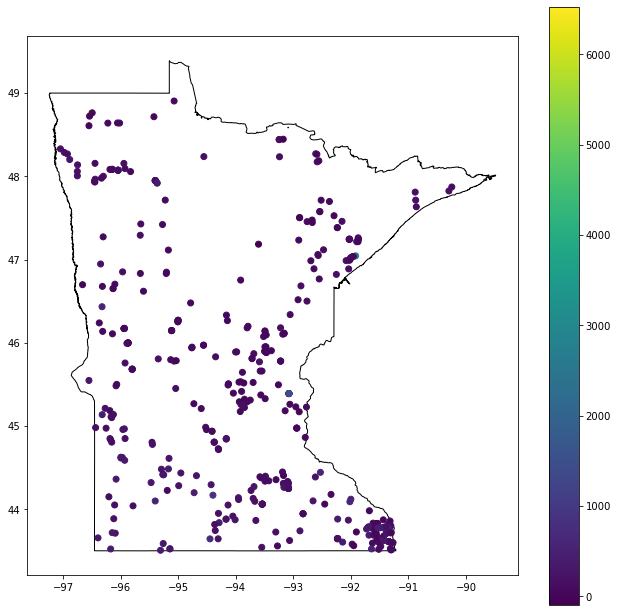

In [38]:
MN = states[(states['NAME']== 'Minnesota')]
base = MN.plot(color='white', edgecolor='black', figsize=(11, 11))

Sites_CSummed_gdf = gpd.GeoDataFrame(Sites_CSummed, geometry='geometry')

#Match crs to our basemap
Sites_CSummed_gdf = Sites_CSummed_gdf.set_crs("EPSG:4269")
Sites_CSummed_gdf = Sites_CSummed_gdf.to_crs(MN.crs)

Sites_CSummed_gdf.plot(ax = base, column = 'carbon_sum', legend = True)

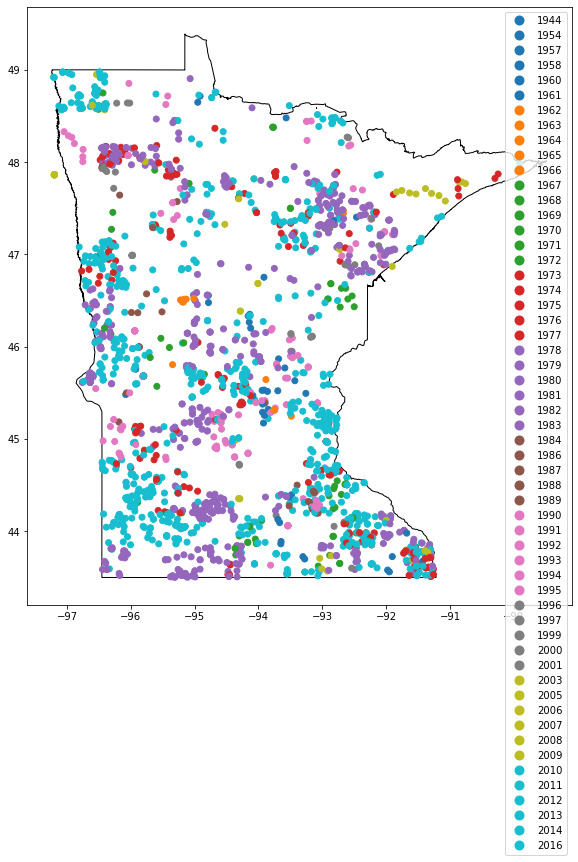

In [39]:
base = MN.plot(color='white', edgecolor='black', figsize=(11, 11))
Sites_CSummed_gdf.plot(ax = base, column = 'year', legend = True)

Ok, there are clearly 2 outliers in terms of carbon along profile be everything else looks all right. We have samples from various years 1960-2011. The points are also really spatially grouped by year, unfortunately. That's going to mean that any dynamic variables are likely more a function of location than they are of year/time. 

## Extract landcover information to soils data

First, get landcover tif file paths and associated years into a dataframe

In [40]:
# a function to strip year from each historic landcover file name
def get_year(filenames):
    Years = []
    for file in filenames: 
        Year = file[-8:-4]
        Years.append(Year)
    return Years

In [41]:
# get list of all landcover file directoryies in a dataframe with their year
files = os.listdir("./MVP1_data/HistoricLandcover/")
Years = get_year(files)
d = {'file':files, 'Year':Years}
LandCover = pd.DataFrame(data = d)

LandCover.head()

,file,Year
0,CONUS_Historical_y1992.tif,1992
1,CONUS_Historical_y1993.tif,1993
2,CONUS_Historical_y1994.tif,1994
3,CONUS_Historical_y1995.tif,1995
4,CONUS_Historical_y1996.tif,1996


Next, use geopandas to sample raster at point data
Inspiration/how to from: https://geopandas.org/en/stable/gallery/geopandas_rasterio_sample.html

In [48]:
# example/testing
YearTest = "./MVP1_data/HistoricLandcover/CONUS_Historical_y1992.tif"
Year = rasterio.open(YearTest)

coord_list = [(x,y) for x,y in zip(Sites_CSummed_gdf['geometry'].x , Sites_CSummed_gdf['geometry'].y)]

Sites_CSummed_gdf['value'] = [x for x in Year.sample(coord_list)]
Sites_CSummed_gdf.head()

,index,site_key,pedon_key,year,geometry,carbon_sum,value
0,0,1654,1654,1954,POINT (188159.296 2321558.225),151.600003,[13]
1,0,1658,1658,1960,POINT (179883.435 2506035.992),22.860000,[8]
2,0,1668,1668,1968,POINT (258622.787 2631673.576),NaN,[5]
3,0,1673,1673,1967,POINT (-21372.328 2718095.823),NaN,[13]
4,0,1681,1681,1972,POINT (189542.480 2725467.781),NaN,[8]


Guess I didn't really need to do this, but visualize pedon points over raster. Zoom in on MN, add key, and maybe change to current year. 

/home/eshook/link0126/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


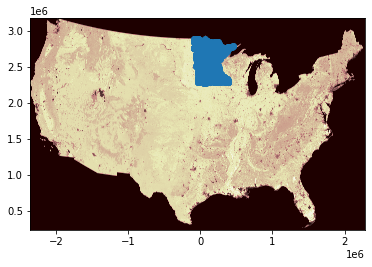

In [43]:
from rasterio.plot import show
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[Year.bounds[0], Year.bounds[2], Year.bounds[1], Year.bounds[3]]
ax = rasterio.plot.show(Year, extent=extent, ax=ax, cmap='pink')

# make sure crs's line up
Sites_CSummed_gdf = Sites_CSummed_gdf.to_crs(Year.crs.data)
Sites_CSummed_gdf.plot(ax=ax)

Finally, write functions to find landcover type at pedon points

In [44]:
# a function that subsets a dataframe, CarbonDf, by unique years and passes it to sample_landcover. Needs LandCover to pass to sample_landcover. 
# returns a new dataframe with landcover class assigned by year
def get_landcover(CarbonDf,LandCover):
    new_df = pd.DataFrame(columns = ['site_key','pedon_key', 'year', 'geometry', 'carbon_sum','value'])
    for year in CarbonDf.year.unique():
        year_sub = CarbonDf[(CarbonDf['year']==year)]
        landcovered = sample_landcover(year_sub,year,LandCover)
        new_df = pd.concat([landcovered,new_df])
    return new_df

# A function that adds the landcover class from a raster from a year to point data. This is making the assumption that there is only one landcover map per year
def sample_landcover(year_sub,year,LandCover):
    ind = LandCover[LandCover['Year']==year].index.values
    tif = LandCover.loc[ind,'file'].tolist()[0]
    tif_path = "./MVP1_data/HistoricLandcover/"+tif
    landcover = rasterio.open(tif_path)
    coord_list = [(x,y) for x,y in zip(year_sub['geometry'].x , Sites_CSummed_gdf['geometry'].y)]
    year_sub['landcover'] = [x for x in landcover.sample(coord_list)]
    return year_sub

In [49]:
# make sure crs's line up
YearTest = "./MVP1_data/HistoricLandcover/CONUS_Historical_y1992.tif"
Year = rasterio.open(YearTest)
Sites_CSummed_gdf = Sites_CSummed_gdf.to_crs(Year.crs.data)

# run my functions
Sites_landcover = get_landcover(Sites_CSummed_gdf,LandCover)

/home/eshook/link0126/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


IndexError: list index out of range

Currently don't know what the landclass values are (need to get that from the raster key), but it worked! And that doesn't matter for the random forest model anyway. 

## Build Predictive Model

I'm going to use a random forest regression model to predict SOC as a function of my environmental variables. I'm going to use sklearn's <RandomForestRegressor>https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    
Obviously this is a silly number of attribtues to build this model on and it's not going to do a good job at all because we don't even trust the soil carbon data that we're feeding it. This is just the skeleton. 

In [23]:
# define the columns we want as dependent (sum of total SOC) and independent (landcover and year)
x = Sites_landcover[['landcover']]
y = Sites_landcover['carbon_sum']

# split the dataframe for 70% training, 30% validation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

NameError: name 'Sites_landcover' is not defined

I establish a baseline, what we want to beat. I'll establish the baseline as the average of the soil C values. 
I don't really expect it to do better than this, and I also know at this point that the training data is wrong. This is more for proof of concept.
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [276]:
# establish baseline error
mean_test = y_test.mean()
baseline_error = abs(mean_test - y_test)
print('Baseline absolute error', round(np.mean(baseline_error),2), 'g/cm^2')

Baseline absolute error 284.52 g/cm^2


In [275]:
# Fit model using Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

# create regressor object
regr = RandomForestRegressor(n_estimators = 100, random_state = 0)

#Fit the regressor with dataframes x_train and y_train
regr.fit(X_train, y_train)  

# Run model on the training dataset
y_pred=regr.predict(X_test)

# Evaluate how the model did using mean square error.  
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

# or we can look at the absolute value of the difference between predicted and "actual"
errors = abs(y_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'g/cm^2')

Mean Absolute Error: 223.9 g/cm^2


In summary, my model technically did slightly better at predicting SOC in profile than randomly choosing the average of the values in the testing dataset. But because the training dataset is so small, this could just be because of the distribution of the points that made it into the training data. I expect if I ran it a few times, it would be a toss up whether the model or average values was better. 

## Why this represents my MVP

This represents what I set out to do in my design framework, though I cut some corners. I calculated total SOC at pedon profile points, though not in a very smooth and robust way; I did not have time to go back and figure out the hard math. I extracted landcover information for the pedons from tifs containing dynamic changes in landcover classes each year. This seems like a bit of a silly thing to do as the pedons contain information about landcover, but if one were to apply this model to predict SOC where it is unknown, you would be using this landcover environmental data. I trained a random forest regression model to predict pedon total SOC as a function of landcover class. The model was not good, but I knew that it would not be. I had hoped that I would get farther, to parts of my MVP that I didn't identify as my goals, and also had hoped that I would be able to work with a larger training dataset. I knew that the soils data would be quite messy, so I tried not to sign myself up for too much and build in a lot of time for data wrangling. I didn't really expect that the data would be *quite* as messy as it was; I had to spend about 2-3 hours just figuring out how it was structured. I was not expecting that the vast majority of the pedons would not have SOC and bulk density information. If I were to continue with this project, I would have to find a more complete dataset (or find the data missing from this one). 

I estimate that I spent around 12 hours on this project. 